# Building your Multimodal Search Store: Enabling Clinical Image Lookup

In this tutorial we will show you how to build and optimize a two-dimensional image search system for chest X-rays using the MedImageInsight embeddings model available on AI Foundry.

## Requirements

* Azure Subscription
* AI Foundry
* AI Search
* GPU Quota to Deploy MedImageInsights
* Python Magic installed to run: https://pypi.org/project/python-magic/

## Our Approach

This tutorial walks you through the use of an embedding model to create a vector index and then build a system that would look up similar images based on image provided. We will first use out-of-the-box capabilities of MedImageInsight model to build a basic system, and show you how you can quickly and easily stand this feature up using AI Search today. 

Ultimately we will build a vector-based search index for X‑ray images. Each image comes with associated metadata—namely, its image name, category, and label. We start by iterating through our catalog of images stored locally. For each image, we use our MedImageParse embedding model (or a similar vectorization function) to generate a high-dimensional embedding vector. These embedding vectors are numerical representations that capture the semantic and visual features of each X‑ray.

After generating the embeddings, we combine them with the metadata to create a set of documents. Each document includes the image’s metadata and its corresponding embedding. We then upload these documents to an Azure Cognitive Search index configured to support vector search. This enables us to perform similarity-based searches—retrieving images that are semantically similar to a given query.

# 0. Imports and Setup

In [199]:
import pandas as pd
import torch
import os
import numpy as np
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
import re
from dotenv import load_dotenv
import base64
import requests
import os
import numpy as np
import json
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
import pandas as pd
import json
import requests
from azure.storage.blob import BlobServiceClient, ContentSettings
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SearchIndex,
    SearchField,
    SimpleField,
    SearchableField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    HnswParameters,
    VectorSearchProfile
)
import os
import pydicom
import matplotlib.pyplot as plt
import requests
from PIL import Image as PILImage
from io import BytesIO
import matplotlib.pyplot as plt
from azure.search.documents.models import VectorizedQuery
from datetime import datetime, timedelta
from azure.storage.blob import BlobClient, BlobSasPermissions, generate_blob_sas

from src.clients.medimageinsight import MedImageInsightClient
from src.utils.io import read_dicom_to_array, normalize_image_to_uint8, numpy_to_image_bytearray

In [200]:
load_dotenv()

search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")  # e.g., "https://<your-search-service>.search.windows.net"
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "med-images-index")
embedding_dim = int(os.environ.get("MEDIMAGEPARSE_MODEL_DIMENSIONS", "1024"))
blob_connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
blob_container_name = os.environ.get("AZURE_IMAGES_CONTAINER_NAME", "medical-images")  # e.g., "xray-images"
root = os.path.dirname(os.getcwd())
images_folder = os.path.join(root, 'utils', 'data', 'images')
images_label_csv = os.path.join(images_folder, '.csv')

# 1. Test MedImageInsights Functionality

200


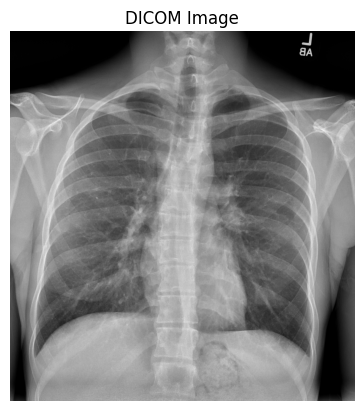

In [201]:
endpoint = os.environ.get("MI2_MODEL_ENDPOINT")
med_image_insight_client = MedImageInsightClient()

import glob
image_files = list(glob.glob(f"{root}/utils/data/images/raw" + "/*.dcm"))

encoded_image=med_image_insight_client._read_and_encode_image(image=image_files[1])

data = {
    "input_data": {
        "columns": ["image", "text"],
        "index": [0],
        "data": [
            [encoded_image, "Cardiomegaly"]
        ],
    },
    "params": {"get_scaling_factor": True},
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {os.environ.get('MI2_MODEL_KEY')}"
}

url = os.environ.get("MI2_MODEL_ENDPOINT")
response = requests.post(url, headers=headers, json=data)
print(response.status_code)

ds = pydicom.dcmread(image_files[1])
img_array = ds.pixel_array

# Display the DICOM image
plt.imshow(img_array, cmap="gray")
plt.title("DICOM Image")
plt.axis("off")
plt.show()

Great! This proves that this works end-to-end to generate embeddings, now let's move onto creating our embedding space as part of our index! Let's save this as our embedding function to generate these in the future.

In [202]:
def generate_medical_embeddings(file_name: str, text_descr: str) -> dict:
    encoded_image=med_image_insight_client._read_and_encode_image(image=image_files[0])
    data = {
        "input_data": {
            "columns": ["image", "text"],
            "index": [0],
            "data": [
                [encoded_image, text_descr]
            ],
        },
        "params": {"get_scaling_factor": True},
    }
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.environ.get('MI2_MODEL_KEY')}"
    }
    
    url = os.environ.get("MI2_MODEL_ENDPOINT")
    response = requests.post(url, headers=headers, json=data)
    return json.loads(response.text)[0]    

# 2. Create the Search Index in AI Search 

We now move onto the next step which is the creation of the AI Search Index. As part of this notebook we are going to create the embedding space for us to conduct our image-to-image lookup on the images.We specifically select the HNSW algorithm to help conduct the nearest-neighbor search retrieval.

For our index we will store the labels of the data which we keep in the `dcm_labels.csv` file, and with it we will include the embeddings and store the actual image onto Azure blob. We want to minimize the amount of data we keep in AI Search due to both limitations on document size as well as impacts on index performance.

Let's begin!

In [203]:
# Helper functions

def upload_dicom_to_blob(file_path: str, container_client, folder: str = "raw") -> str:
    """
    Uploads a file to Blob Storage into a specified folder.
    If the blob already exists, the function returns its URL without re-uploading.
    """
    file_name = os.path.basename(file_path)
    # Create a blob name that places the file under the "raw" folder
    blob_name = f"{folder}/{file_name}"
    blob_client = container_client.get_blob_client(blob_name)
    
    # Check if the blob already exists; if so, skip upload
    if blob_client.exists():
        return blob_client.url
    
    with open(file_path, "rb") as data:
        blob_client.upload_blob(
            data, 
            overwrite=True, 
            content_settings=ContentSettings(content_type="application/dicom")
        )
    return blob_client.url

def normalize_document_key(key: str) -> str:
    """
    Normalize a document key by replacing any character not in the allowed set
    (letters, digits, underscore, dash, or equal sign) with an underscore.
    """
    # Allowed characters: A-Z, a-z, 0-9, underscore, dash, equal sign.
    normalized_key = re.sub(r"[^A-Za-z0-9_\-=]", "_", key)
    return normalized_key

In [204]:
# labeled images
dcm_labels = os.path.join(root, "utils", "data", "images", "dcm_labels.csv")

# storage helpers
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(blob_container_name)

# search
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

In [205]:
df = pd.read_csv(dcm_labels)
df = df.rename(columns={
    "Name": "name",
    "Label Category": "label_category",
    "Label": "label"
})

In [ ]:
documents = []  # list of documents to upsert in Azure Search
image_folder = os.path.join(root, "utils", "data", "images", "raw") 

# upload into blob and generate the DF for Search processing
for idx, row in df.iterrows():
    file_name = row["name"]
    # Construct the full path to the DICOM file
    file_path = os.path.join(image_folder, file_name)
    
    # Upload the file to Blob Storage under the "raw" folder
    blob_url = upload_dicom_to_blob(file_path, container_client, folder="raw")
    
    # Combine text description for embedding generation (e.g., label_category + label)
    text_descr = f"{row['label_category']}"
    
    # Generate the embedding and scaling factor using the helper function
    embedding_result = generate_medical_embeddings(file_path, text_descr)
    vector = embedding_result.get("image_features") # the embedding vector
    scaling_factor = embedding_result.get("scaling_factor")
    
    # Create a document matching the Azure Search index schema
    doc = {
        "name": normalize_document_key(file_name),
        "label_category": row["label_category"],
        "label": str(row["label"]),
        "vector": vector[0],
        "blob_url": blob_url,
        "scaling_factor": scaling_factor
    }
    documents.append(doc)

Define the definition of the index and load our documents!

In [179]:
# Define the index fields
fields = [
    # The 'name' field is used as the unique key
    SimpleField(
        name="name",
        type=SearchFieldDataType.String,
        key=True,
        retrievable=True,
        sortable=True,
        filterable=True
    ),
    # Searchable text fields for metadata
    SearchableField(name="label_category", type=SearchFieldDataType.String),
    SearchableField(name="label", type=SearchFieldDataType.Int32),
    # The vector field; must be defined with the proper dimension and linked to a vector search profile
    SearchField(
        name="vector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        vector_search_dimensions=embedding_dim,
        vector_search_profile_name="myHnswNewProfile"
    ),
    # The blob URL where the image is stored
    SimpleField(
        name="blob_url",
        type=SearchFieldDataType.String,
        retrievable=True
    ),
    # The scaling factor from your embedding response
    SimpleField(
        name="scaling_factor",
        type=SearchFieldDataType.Double,
        retrievable=True
    )
]

# Configure the vector search settings using the HNSW algorithm
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnswNew",
            parameters=HnswParameters(
                m=4, 
                ef_construction=400,
                ef_search=500 
            )
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswNewProfile",
            algorithm_configuration_name="myHnswNew"
        )
    ]
)

# Create the SearchIndex object including the fields and the vector search configuration
index = SearchIndex(
    name=search_index_name,
    fields=fields,
    vector_search=vector_search
)

index_client = SearchIndexClient(
    endpoint=search_endpoint,
    credential=AzureKeyCredential(search_admin_key)
)

result = index_client.create_or_update_index(index)
print(f"Index '{result.name}' created or updated successfully.")

Index 'med-images-index' created or updated successfully.


In [186]:
# upload the documents to search
try:
    upload_result = search_client.upload_documents(documents=documents)
except Exception as e:
    print("Error uploading documents:", e)

# 3. Baseline Search and Retrieve Using Images!

Now comes all the fun: putting it altogether! We have now successfully built a Search Index using MedImageParse embeddings and will now move onto the stage of turning this into an end to end multi-modal knowledge store. Now we will:

1. Select an image and label from our corpus and generate embeddings
2. Use those embeddings to retrieve results from our newly created index
3. Display the top-n results from the index to demonstrate similarity

In [196]:
def get_blob_sas_url(blob_url: str, expiry_hours: int = 1) -> str:
    """
    Given a blob URL, generate and return a SAS URL that appends a read-only token.
    The account key must be set in the environment variable 'AZURE_STORAGE_ACCOUNT_KEY'.
    """
    account_key = os.environ.get("AZURE_STORAGE_ACCOUNT_KEY")
    if not account_key:
        raise ValueError("AZURE_STORAGE_ACCOUNT_KEY environment variable is not set.")
    
    blob_client = BlobClient.from_blob_url(blob_url)
    sas_token = generate_blob_sas(
        account_name=blob_client.account_name,
        container_name=blob_client.container_name,
        blob_name=blob_client.blob_name,
        account_key=account_key,
        permission=BlobSasPermissions(read=True),
        expiry=datetime.utcnow() + timedelta(hours=expiry_hours)
    )
    return blob_client.url + "?" + sas_token

def display_source_and_results(doc_index: int, search_client, documents, k: int = 5):
    """
    Given a document index from the documents list, this function:
      1. Retrieves the source DICOM image using its blob URL, converts it to an image,
         and displays it.
      2. Uses the document's embedding vector to perform a vector search in Azure Cognitive Search.
      3. Displays the source image and the top k similar images (excluding the source),
         annotated with rank, label, and label_category.
         
    The DICOM-to-image conversion uses:
       - read_dicom_to_array to read the DICOM bytes,
       - normalize_image_to_uint8 to normalize the pixel values,
       - numpy_to_image_bytearray to convert the array to a PNG byte stream.
    """
    # Select the source document
    source_doc = documents[doc_index]
    source_blob_url = source_doc['blob_url']
    source_vector = source_doc['vector']
    source_label_category = source_doc.get("label_category", "Unknown Category")

    # Generate a SAS URL for the source DICOM blob
    sas_source_url = get_blob_sas_url(source_blob_url)
    
    # Download the DICOM bytes from blob
    response = requests.get(sas_source_url)
    if response.status_code == 200:
        # Use your helper function to read the DICOM bytes to a NumPy array
        dicom_array = read_dicom_to_array(response.content, engine="sitk")
        # Normalize the array to uint8 (you may adjust parameters as needed)
        normalized_array = normalize_image_to_uint8(dicom_array)
        # Convert the normalized NumPy array to image bytes (PNG format)
        img_bytes = numpy_to_image_bytearray(normalized_array, format="PNG")
        # Open the image with PIL
        source_img = PILImage.open(BytesIO(img_bytes))
    else:
        print(f"Failed to retrieve source image. Status code: {response.status_code}")
        return

    # Build a vector query using the source document's vector
    vector_query = VectorizedQuery(
        vector=source_vector,
        k_nearest_neighbors=k,  # k+1 to account for potential inclusion of the source itself
        fields="vector"
    )
    
    # Execute the vector search
    search_results = search_client.search(search_text=None, vector_queries=[vector_query])
    result_docs = [doc for doc in search_results]
    
    # Filter out the source document by comparing the normalized 'name' field
    filtered_results = [doc for doc in result_docs if doc.get("name") != source_doc["name"]]
    top_results = filtered_results[:k]

    # Create a matplotlib figure with subplots for source and result images
    total_images = 1 + len(top_results)
    fig, axes = plt.subplots(1, total_images, figsize=(4 * total_images, 4))
    if total_images == 1:
        axes = [axes]

    # Display the source image in the first subplot
    axes[0].imshow(source_img, cmap="gray")
    axes[0].set_title(f"Source Image\nCategory: {source_label_category}")
    axes[0].axis("off")
    
    # Display each result: download its DICOM, process, and show with annotations
    for i, doc in enumerate(top_results):
        result_blob_url = doc.get("blob_url")
        sas_url = get_blob_sas_url(result_blob_url)
        r = requests.get(sas_url)
        if r.status_code == 200:
            dicom_array_res = read_dicom_to_array(r.content, engine="sitk")
            norm_array_res = normalize_image_to_uint8(dicom_array_res)
            img_bytes_res = numpy_to_image_bytearray(norm_array_res, format="PNG")
            result_img = PILImage.open(BytesIO(img_bytes_res))
        else:
            print(f"Failed to retrieve image for result {i+1}. Status code: {r.status_code}")
            continue
        
        label = doc.get("label")
        label_category = doc.get("label_category")
        axes[i+1].imshow(result_img, cmap="gray")
        axes[i+1].set_title(f"Rank {i+1}\n{label_category}\n{label}")
        axes[i+1].axis("off")
    
    plt.tight_layout()
    plt.show()

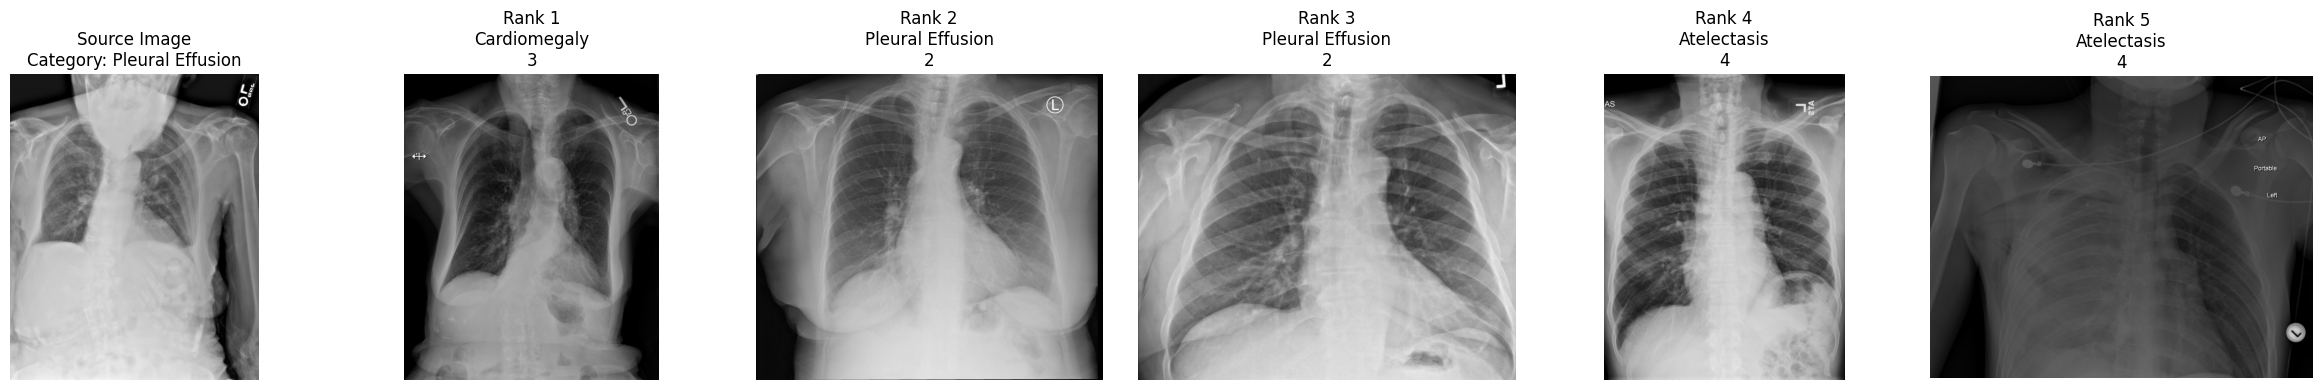

In [197]:
display_source_and_results(doc_index=40, search_client=search_client, documents=documents, k=5)

# 4. Optimizing Performance and Image Search

This is an end-to-end notebook highlighting how you can use AI Search with medical images, but is not the end. Stay tuned for additional updates to this repository where we further fine-tune the models and evaluate it for performance using neural networks and optimizing for our classification use case. 

initial benchmarking showcases that there is precision to be gained as effectiveness wanes, but this is expected! The embedding space is sparse, and just like in other Generative AI applications iterative tuning is required to further yield better results.

If you wish to see more, please reference our colleagues existing work completed at: https://github.com/microsoft/healthcareai-examples/blob/main/azureml/medimageinsight/adapter-training.ipynb


